# Unsupervised Classification of Sleep Stages in Rat EEG Signal Data

This notebook implements a deep learning pipeline for unsupervised classification of sleep stages in rat EEG signal data. The pipeline includes preprocessing steps, feature extraction using Dynamic Mode Decomposition (DMD), and a transformer-based architecture for clustering.

## Import Required Libraries

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.interpolate import interp1d

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For DMD
from pydmd import DMD

# Set plotting style
plt.style.use('default')  # Use default style instead of deprecated seaborn-whitegrid
sns.set_theme(style="whitegrid")  # Use the newer seaborn API
sns.set_context("notebook", font_scale=1.5)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load and Inspect EEG Signal Data

We'll load the EEG signal data from a file and visualize it to understand its structure and characteristics.

## Bandpass Filter the Signal

Apply a bandpass filter to the EEG signal in the range of 0.5 Hz to 100 Hz using SciPy's signal processing tools.

Extracting EDF parameters from /home/yahia/notebooks/by captain borat/raw/EEG_0_per_hour_2024-03-20 17_12_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44153855  =      0.000 ... 86237.998 secs...
Reading 0 ... 44153855  =      0.000 ... 86237.998 secs...


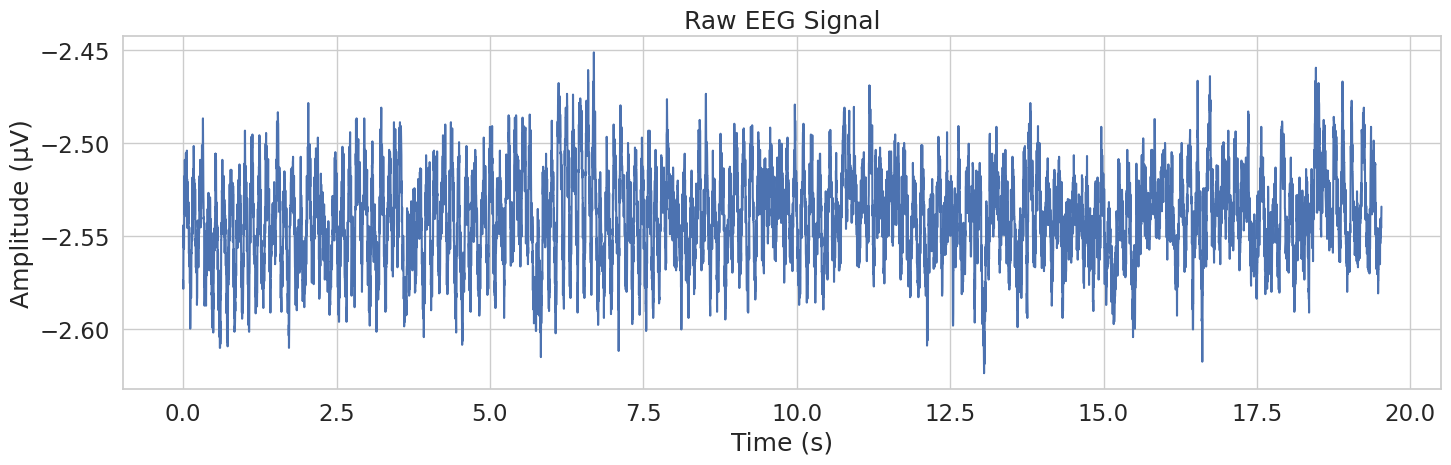

Loaded EEG signal with 44153856 samples
Sampling rate: 512.0 Hz
Recording duration: 86238.00 seconds (1437.30 minutes)
Min value: -2.79, Max value: 1.67


In [5]:
import os
import numpy as np

import matplotlib.pyplot as plt
import mne  # For EEG data processing

# Load EEG data from EDF file
try:
    file_path = "by captain borat/raw/EEG_0_per_hour_2024-03-20 17_12_18.edf"
    
    # Load the EDF file using MNE
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Get EEG data and time vector
    eeg_signal = raw.get_data()[0]  # Assuming first channel is the EEG data
    
    # Create time vector (in seconds)
    sampling_rate = raw.info['sfreq']
    time = np.arange(0, len(eeg_signal) / sampling_rate, 1 / sampling_rate)
    
    # Plot a segment of the raw EEG data
    plt.figure(figsize=(15, 5))
    plt.plot(time[:10000], eeg_signal[:10000])
    plt.title('Raw EEG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (μV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Display information about the data
    print(f"Loaded EEG signal with {len(eeg_signal)} samples")
    print(f"Sampling rate: {sampling_rate} Hz")
    print(f"Recording duration: {len(eeg_signal)/sampling_rate:.2f} seconds ({len(eeg_signal)/sampling_rate/60:.2f} minutes)")
    print(f"Min value: {eeg_signal.min():.2f}, Max value: {eeg_signal.max():.2f}")
    
except Exception as e:
    print(f"Error loading EEG data: {e}")
    
    # If loading fails, create synthetic data for testing
    print("Creating synthetic EEG data for testing...")
    sampling_rate = 250.0  # Hz
    duration = 600  # seconds
    t = np.arange(0, duration, 1.0/sampling_rate)
    
    # Create synthetic EEG with different frequency bands
    delta = 0.5 * np.sin(2 * np.pi * 2 * t)  # Delta: 0.5-4 Hz
    theta = 0.2 * np.sin(2 * np.pi * 6 * t)  # Theta: 4-8 Hz
    alpha = 0.4 * np.sin(2 * np.pi * 10 * t)  # Alpha: 8-13 Hz
    beta = 0.1 * np.sin(2 * np.pi * 20 * t)  # Beta: 13-30 Hz
    
    # Add random noise
    noise = 0.1 * np.random.randn(len(t))
    
    # Combine all components
    eeg_signal = delta + theta + alpha + beta + noise
    time = t
    
    # Plot the synthetic EEG
    plt.figure(figsize=(15, 5))
    plt.plot(time[:2500], eeg_signal[:2500])
    plt.title('Synthetic EEG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print(f"Created synthetic EEG signal with {len(eeg_signal)} samples")
    print(f"Sampling rate: {sampling_rate} Hz")
    print(f"Duration: {duration} seconds ({duration/60:.2f} minutes)")

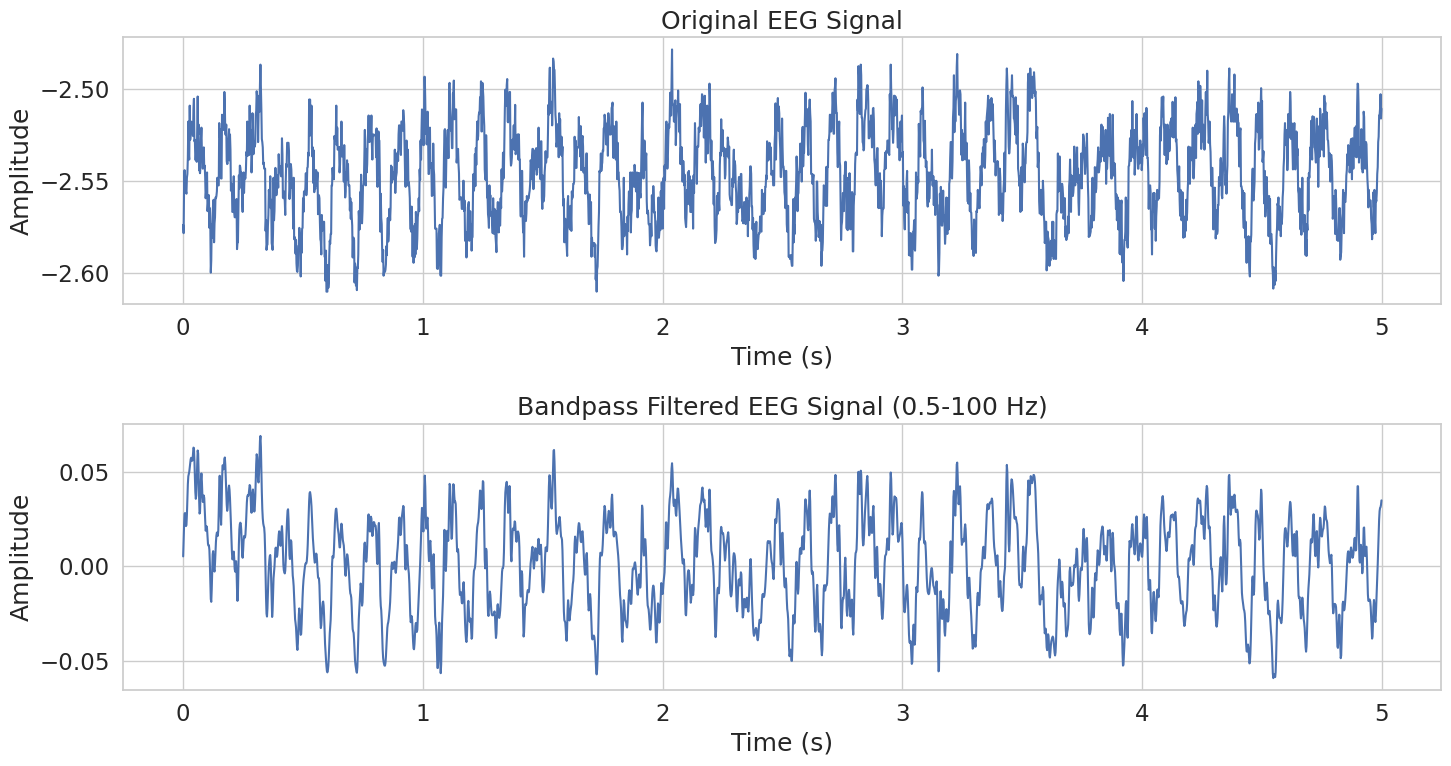

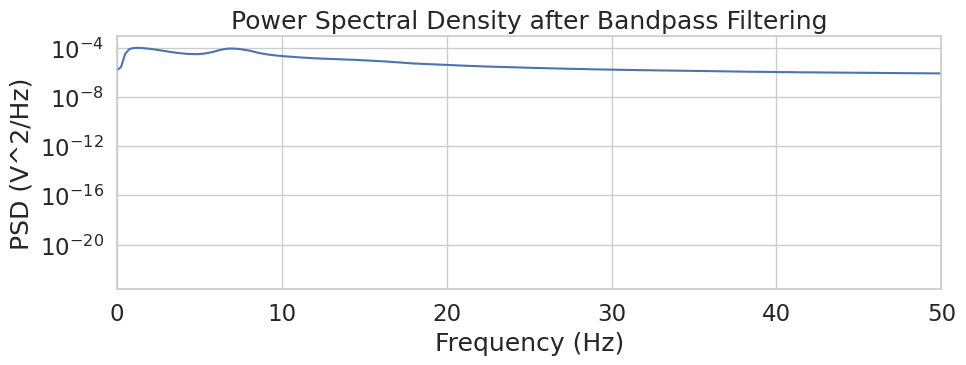

In [6]:
# Define filter parameters
fs = len(eeg_signal) / time[-1]  # Sampling frequency
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 100  # Upper cutoff frequency (Hz)
order = 4  # Filter order

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Apply bandpass filter
filtered_eeg = bandpass_filter(eeg_signal, lowcut, highcut, fs, order)

# Plot original vs filtered signal
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(time[:2560], eeg_signal[:2560])
plt.title('Original EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time[:2560], filtered_eeg[:2560])
plt.title('Bandpass Filtered EEG Signal (0.5-100 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Calculate and print the power spectral density
f, Pxx = signal.welch(filtered_eeg, fs, nperseg=2048)
plt.figure(figsize=(10, 4))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.title('Power Spectral Density after Bandpass Filtering')
plt.xlim(0, 50)  # Display up to 50 Hz
plt.grid(True)
plt.tight_layout()
plt.show()

## Normalize the Signal

Normalize the EEG signal to have zero mean and unit variance.

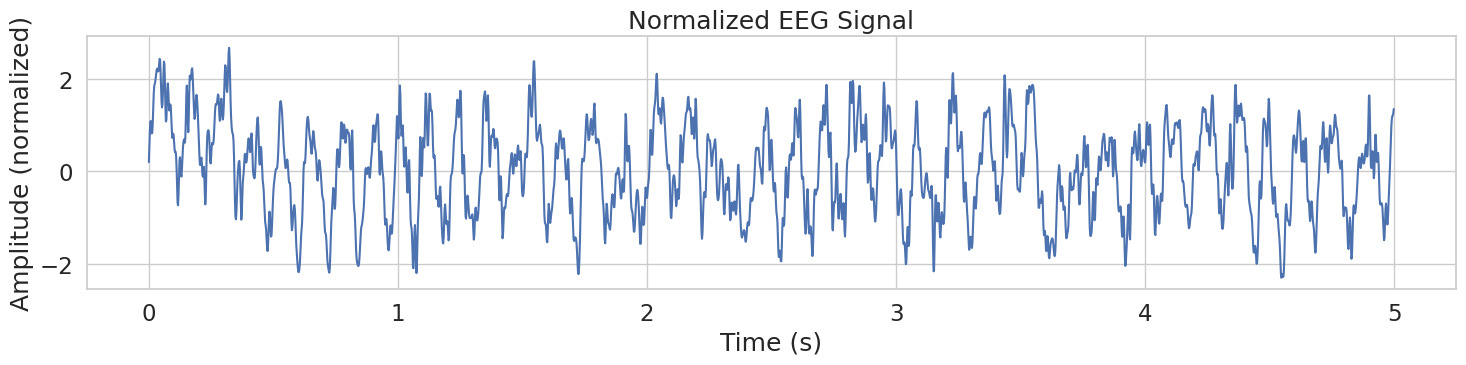

Mean after normalization: -0.00000000
Std deviation after normalization: 1.00000000
Std deviation after normalization: 1.00000000


In [7]:
# Normalize the filtered EEG signal
scaler = StandardScaler()
normalized_eeg = scaler.fit_transform(filtered_eeg.reshape(-1, 1)).flatten()

# Plot the normalized signal
plt.figure(figsize=(15, 4))
plt.plot(time[:2560], normalized_eeg[:2560])
plt.title('Normalized EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display statistics after normalization
print(f"Mean after normalization: {np.mean(normalized_eeg):.8f}")
print(f"Std deviation after normalization: {np.std(normalized_eeg):.8f}")

## Interpolate Signal Using Sliding Windows

Interpolate the signal on 3x standard deviation using sliding windows of 30 seconds length.

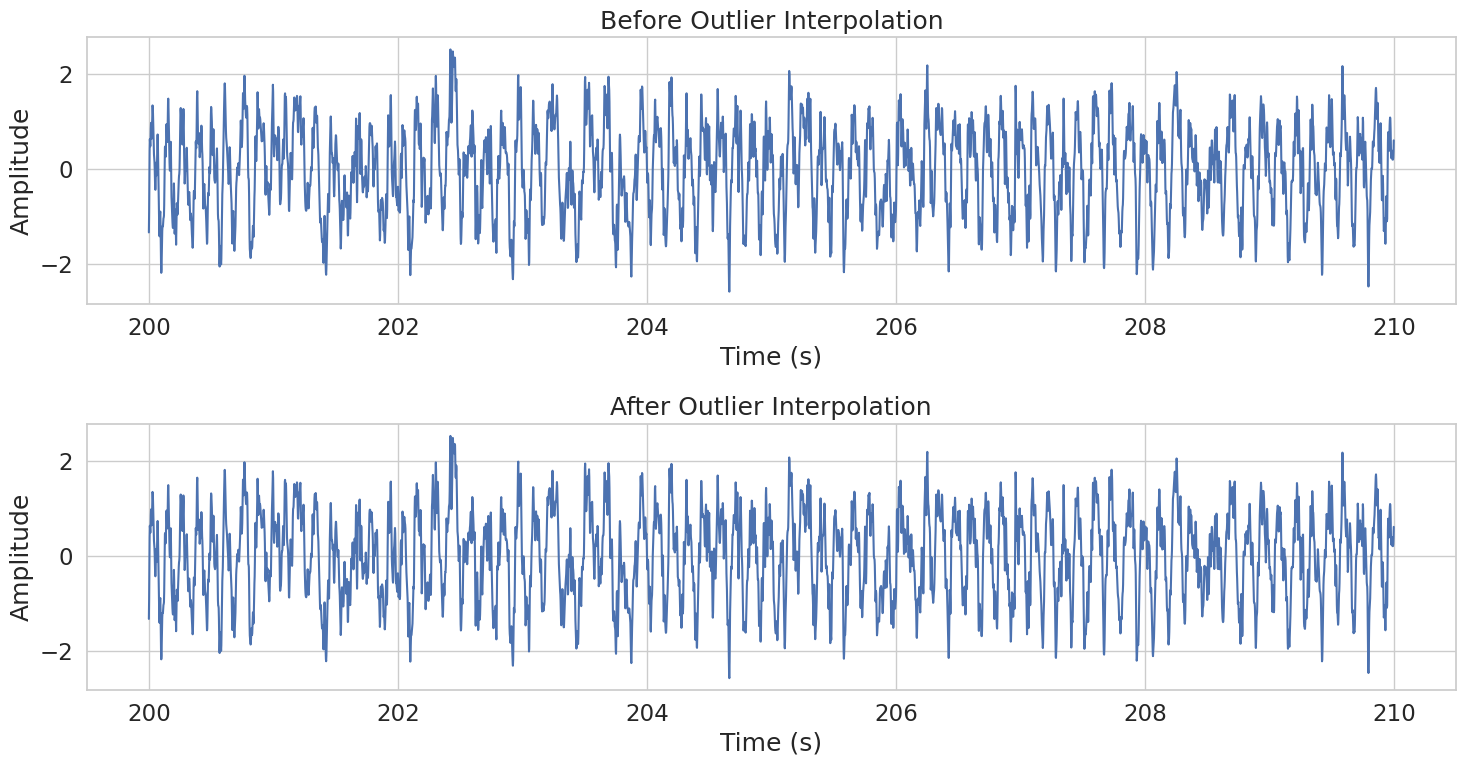

In [9]:
# Define parameters for sliding windows
window_size = 30 * int(fs)  # 30 seconds window
step_size = window_size // 2  # 50% overlap

def interpolate_outliers(signal, threshold=3):
    """
    Interpolate values exceeding specified standard deviation threshold
    
    Parameters:
    - signal: input signal array
    - threshold: number of standard deviations to use as threshold
    
    Returns:
    - interpolated signal
    """
    mean = np.mean(signal)
    std = np.std(signal)
    
    # Find outliers
    outlier_indices = np.where(np.abs(signal - mean) > threshold * std)[0]
    
    if len(outlier_indices) == 0:
        return signal.copy()
    
    # Create copy of the signal
    processed_signal = signal.copy()
    
    # Get indices of non-outliers
    valid_indices = np.where(np.abs(signal - mean) <= threshold * std)[0]
    
    if len(valid_indices) < 2:
        return signal.copy()  # Can't interpolate with less than 2 points
    
    # Create interpolation function
    interp_func = interp1d(valid_indices, signal[valid_indices], 
                          kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Replace outliers with interpolated values
    processed_signal[outlier_indices] = interp_func(outlier_indices)
    
    return processed_signal

# Process signal in sliding windows
interpolated_eeg = np.zeros_like(normalized_eeg)
num_windows = (len(normalized_eeg) - window_size) // step_size + 1

for i in range(num_windows):
    start_idx = i * step_size
    end_idx = start_idx + window_size
    
    if end_idx > len(normalized_eeg):
        break
    
    # Get window
    window = normalized_eeg[start_idx:end_idx]
    
    # Interpolate outliers in this window
    interpolated_window = interpolate_outliers(window, threshold=3)
    
    # Apply window to output with overlap
    if i == 0:
        interpolated_eeg[start_idx:end_idx] = interpolated_window
    else:
        # Linear crossfade in the overlap region
        overlap_start = start_idx
        overlap_end = start_idx + step_size
        
        # Create fade in/out weights
        fade_in = np.linspace(0, 1, step_size)
        fade_out = np.linspace(1, 0, step_size)
        
        # Apply crossfade
        interpolated_eeg[overlap_start:overlap_end] = (
            fade_out * interpolated_eeg[overlap_start:overlap_end] + 
            fade_in * interpolated_window[:step_size]
        )
        
        # Copy non-overlapping part
        interpolated_eeg[overlap_end:end_idx] = interpolated_window[step_size:]

# Handle last part if needed
if end_idx < len(normalized_eeg):
    last_window = normalized_eeg[-window_size:]
    last_interpolated = interpolate_outliers(last_window, threshold=3)
    
    # Only use the part we need
    overlap = len(normalized_eeg) - end_idx
    interpolated_eeg[-overlap:] = last_interpolated[-overlap:]

# Plot comparison of a segment of the signal before and after interpolation
segment_start = 200 * int(fs)  # Start at 200 seconds
segment_length = 10 * int(fs)  # Show 10 seconds

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(time[segment_start:segment_start+segment_length], 
         normalized_eeg[segment_start:segment_start+segment_length])
plt.title('Before Outlier Interpolation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(time[segment_start:segment_start+segment_length], 
         interpolated_eeg[segment_start:segment_start+segment_length])
plt.title('After Outlier Interpolation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Apply Dynamic Mode Decomposition (DMD)

Use DMD to extract features and reduce the dimensions of the EEG signal data.

In [12]:
# Prepare data for DMD
# We'll use sliding windows to create snapshots for DMD

def create_snapshots(signal, window_size, step_size):
    """
    Create snapshots of signal for DMD
    
    Parameters:
    - signal: input signal array
    - window_size: size of each snapshot window
    - step_size: step size between consecutive windows
    
    Returns:
    - snapshots matrix where each column is a snapshot
    - indices array indicating the starting index of each snapshot
    """
    n_samples = len(signal)
    n_snapshots = (n_samples - window_size) // step_size + 1
    
    snapshots = np.zeros((window_size, n_snapshots))
    indices = np.zeros(n_snapshots, dtype=int)
    
    for i in range(n_snapshots):
        start_idx = i * step_size
        indices[i] = start_idx
        snapshots[:, i] = signal[start_idx:start_idx + window_size]
    
    return snapshots, indices


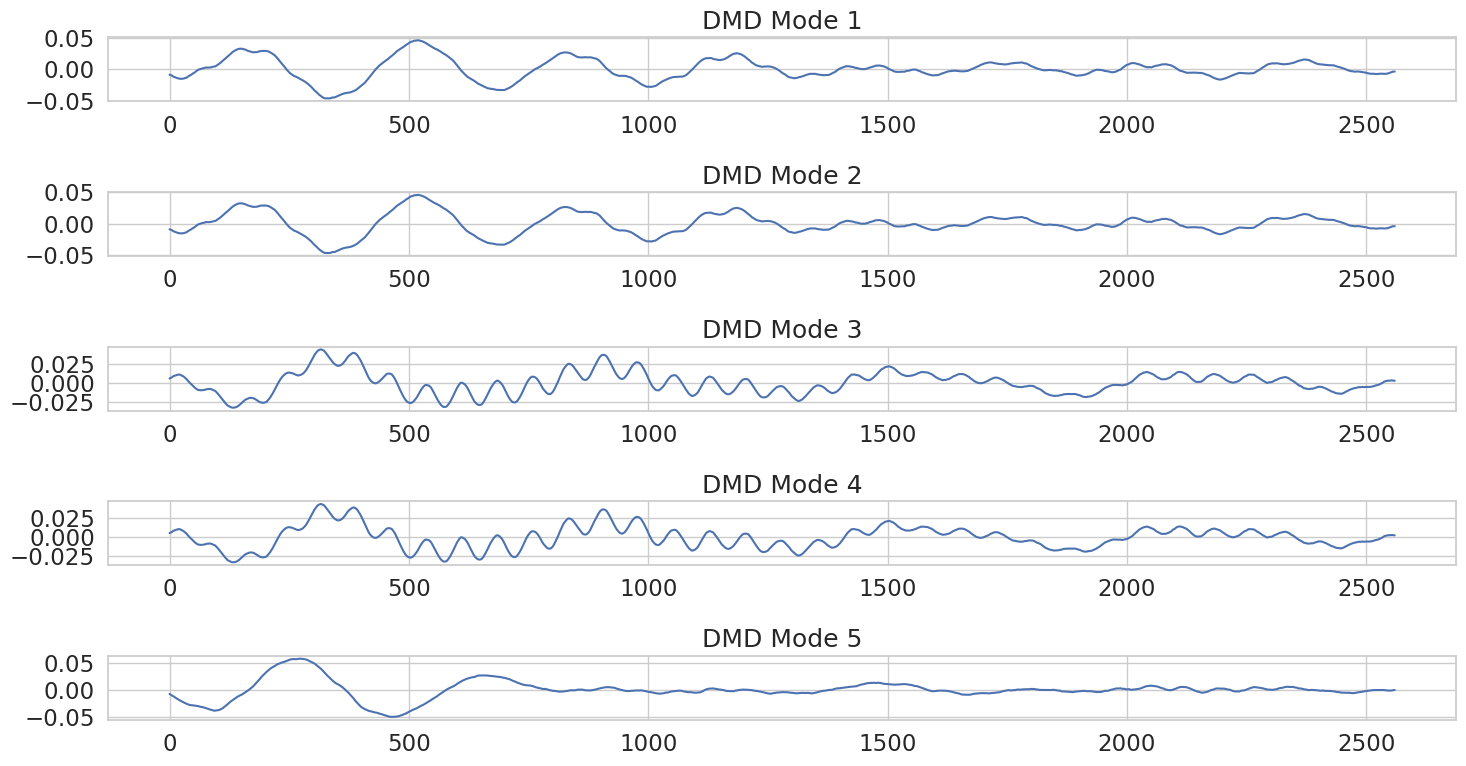

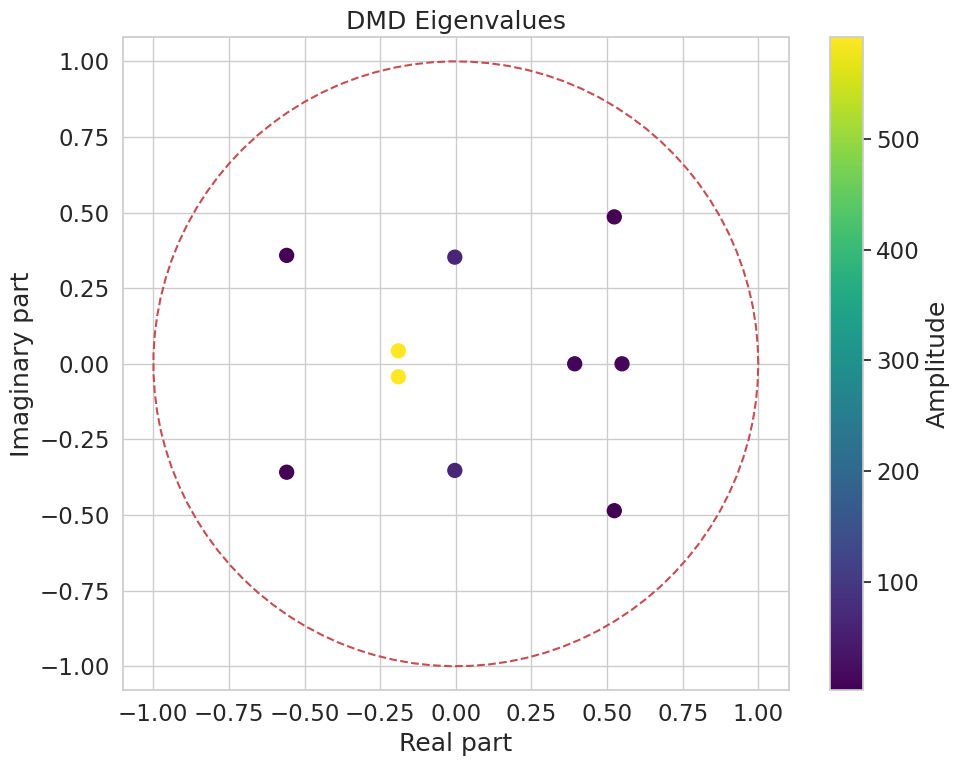

Shape of DMD features: (86234, 20)


In [13]:

# Create snapshots for DMD
dmd_window_size = 5 * int(fs)  # 5 second windows
dmd_step_size = int(fs)        # 1 second step

snapshots, snapshot_indices = create_snapshots(interpolated_eeg, dmd_window_size, dmd_step_size)

# Apply DMD
n_modes = 10  # Number of modes to compute
dmd = DMD(svd_rank=n_modes)
dmd.fit(snapshots)

# Extract DMD features for each snapshot
dmd_features = np.zeros((len(snapshot_indices), n_modes), dtype=complex)

for i in range(len(snapshot_indices)):
    snapshot = snapshots[:, i].reshape(-1, 1)
    dmd_features[i, :] = dmd.amplitudes

# Convert to real features (magnitude and phase)
dmd_features_real = np.zeros((len(snapshot_indices), 2 * n_modes))
dmd_features_real[:, :n_modes] = np.abs(dmd_features)  # Magnitude
dmd_features_real[:, n_modes:] = np.angle(dmd_features)  # Phase

# Normalize features
dmd_features_normalized = StandardScaler().fit_transform(dmd_features_real)

# Visualize the DMD modes and eigenvalues
plt.figure(figsize=(15, 8))

# Plot first 5 DMD modes
for i in range(min(5, n_modes)):
    plt.subplot(5, 1, i+1)
    plt.plot(np.real(dmd.modes[:, i]))
    plt.title(f'DMD Mode {i+1}')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Plot DMD spectrum (eigenvalues)
plt.figure(figsize=(10, 8))
eigs = dmd.eigs
plt.scatter(eigs.real, eigs.imag, c=np.abs(dmd.amplitudes), s=100, cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('DMD Eigenvalues')
plt.grid(True)
plt.axis('equal')

# Draw unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'r--')

plt.tight_layout()
plt.show()

print(f"Shape of DMD features: {dmd_features_normalized.shape}")

In [30]:
# Create sequences from the DMD features for the transformer model
seq_length = 20  # Number of time steps in each sequence
seq_step_size = 5  # Step size between sequences

def create_sequences(features, seq_length=20, step_size=5):
    """Create sequences from features with a sliding window"""
    sequences = []
    for i in range(0, len(features) - seq_length + 1, step_size):
        sequences.append(features[i:i+seq_length])
    return np.array(sequences)

# Create sequences
sequences = create_sequences(dmd_features_normalized, seq_length, seq_step_size)
print(f"Created {len(sequences)} sequences of length {seq_length}")

# Convert to PyTorch tensor
sequences_tensor = torch.FloatTensor(sequences)

# Create dataset and dataloader
dataset = TensorDataset(sequences_tensor, sequences_tensor)  # Self-supervised (no labels)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
input_dim = dmd_features_normalized.shape[1]  # Number of features
hidden_dim = 64
num_clusters = 4

model = TransformerEncoder(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_heads=4,
    num_layers=2,
    dropout=0.1,
    num_clusters=num_clusters
).to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize loss function
criterion = ClusteringLoss(lambda_recon=1.0, lambda_cluster=0.1, lambda_reg=0.01)

print(f"Model created with input dimension {input_dim}")

Created 17243 sequences of length 20
Model created with input dimension 20


## Define Transformer-Based Deep Learning Model

Implement a transformer-based architecture in PyTorch for unsupervised clustering of the EEG signal.

In [24]:
# Define transformer encoder based architecture
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_layers=2, dropout=0.1, num_clusters=4):
        super().__init__()
        
        self.num_clusters = num_clusters
        self.input_dim = input_dim  # Store input dimension for later use
        
        # Input embedding
        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        
        # Position encoding
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, hidden_dim))  # Max sequence length of 1000
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Clustering layers
        self.feature_projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2)
        )
        
        # Cluster centroids (learnable)
        self.cluster_centroids = nn.Parameter(torch.randn(num_clusters, hidden_dim // 2))
        
        # Decoder for reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Input embedding
        x = self.input_embedding(x)
        
        # Add positional encoding
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Apply transformer encoder
        x = self.transformer(x)
        
        # Get sequence representation (average pooling over sequence)
        x_pooled = torch.mean(x, dim=1)
        
        # Project to feature space
        features = self.feature_projection(x_pooled)
        
        # Reconstruct input - reconstruct the first time step as a representative
        reconstructed = self.decoder(features)  # This outputs [batch_size, input_dim]
        
        # Calculate distances to cluster centroids
        centroids_expanded = self.cluster_centroids.unsqueeze(0).repeat(batch_size, 1, 1)
        features_expanded = features.unsqueeze(1).repeat(1, self.num_clusters, 1)
        
        # Calculate Euclidean distances 
        distances = torch.sum((features_expanded - centroids_expanded) ** 2, dim=-1)
        
        # Convert distances to probabilities (soft assignment)
        cluster_probs = torch.softmax(-distances, dim=-1)
        
        return {
            'features': features,
            'cluster_probs': cluster_probs,
            'reconstructed': reconstructed,
            'centroids': self.cluster_centroids
        }
        
    def predict_cluster(self, x):
        with torch.no_grad():
            outputs = self(x)
            cluster_probs = outputs['cluster_probs']
            _, cluster_idx = torch.max(cluster_probs, dim=1)
            return cluster_idx

# Custom loss function for unsupervised clustering
class ClusteringLoss(nn.Module):
    def __init__(self, lambda_recon=1.0, lambda_cluster=0.1, lambda_reg=0.01):
        super().__init__()
        self.lambda_recon = lambda_recon
        self.lambda_cluster = lambda_cluster
        self.lambda_reg = lambda_reg
        self.mse_loss = nn.MSELoss()
        
    def forward(self, inputs, outputs):
        # Reconstruction loss - compare with first time step of each sequence
        # We need to reshape the reconstructed output to match the input's first time step
        first_timestep = inputs[:, 0, :]  # [batch_size, input_dim]
        recon_loss = self.mse_loss(outputs['reconstructed'], first_timestep)
        
        # Clustering loss (maximize cluster assignment certainty)
        cluster_probs = outputs['cluster_probs']
        entropy = -torch.mean(torch.sum(cluster_probs * torch.log(cluster_probs + 1e-10), dim=1))
        
        # Regularization to prevent cluster collapse (encourage uniform distribution)
        avg_cluster_probs = torch.mean(cluster_probs, dim=0)
        uniform_target = torch.ones_like(avg_cluster_probs) / avg_cluster_probs.shape[0]
        reg_loss = torch.sum((avg_cluster_probs - uniform_target) ** 2)
        
        # Combined loss
        total_loss = (
            self.lambda_recon * recon_loss + 
            self.lambda_cluster * entropy + 
            self.lambda_reg * reg_loss
        )
        
        return {
            'total_loss': total_loss,
            'recon_loss': recon_loss,
            'entropy': entropy,
            'reg_loss': reg_loss
        }

Epoch [10/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [20/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [20/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [30/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [30/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [40/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [40/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [50/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [50/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [60/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [60/100], Total Loss: 0.0075, Recon Loss: 0.0000, Entropy: 0.0000, Reg Loss: 0.7500
Epoch [70/

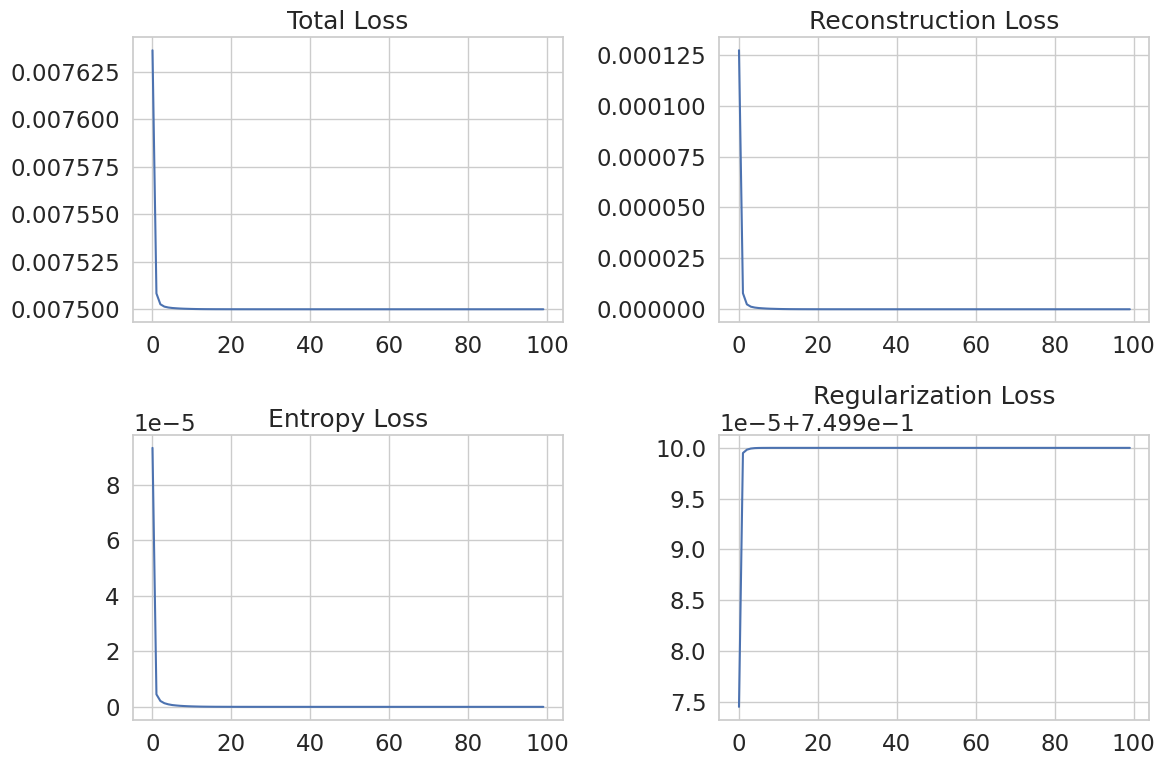

Training completed!


In [25]:
# Training loop
num_epochs = 100
log_interval = 10
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_recon_loss = 0.0
    epoch_entropy = 0.0
    epoch_reg_loss = 0.0
    
    model.train()
    
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        
        # Forward pass
        outputs = model(data)
        
        # Calculate loss
        loss_dict = criterion(data, outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        # Track losses
        epoch_loss += loss_dict['total_loss'].item()
        epoch_recon_loss += loss_dict['recon_loss'].item()
        epoch_entropy += loss_dict['entropy'].item()
        epoch_reg_loss += loss_dict['reg_loss'].item()
    
    # Average losses for the epoch
    epoch_loss /= len(dataloader)
    epoch_recon_loss /= len(dataloader)
    epoch_entropy /= len(dataloader)
    epoch_reg_loss /= len(dataloader)
    
    losses.append((epoch_loss, epoch_recon_loss, epoch_entropy, epoch_reg_loss))
    
    if (epoch + 1) % log_interval == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Total Loss: {epoch_loss:.4f}, "
              f"Recon Loss: {epoch_recon_loss:.4f}, "
              f"Entropy: {epoch_entropy:.4f}, "
              f"Reg Loss: {epoch_reg_loss:.4f}")

# Plot training curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot([x[0] for x in losses])
plt.title('Total Loss')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot([x[1] for x in losses])
plt.title('Reconstruction Loss')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot([x[2] for x in losses])
plt.title('Entropy Loss')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot([x[3] for x in losses])
plt.title('Regularization Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Training completed!")

In [26]:
# Make predictions on all sequences
model.eval()

with torch.no_grad():
    # Process in batches to avoid memory issues
    all_features = []
    all_predictions = []
    
    for i in range(0, len(sequences_tensor), batch_size):
        batch = sequences_tensor[i:i+batch_size].to(device)
        outputs = model(batch)
        features = outputs['features'].cpu().numpy()
        preds = model.predict_cluster(batch).cpu().numpy()
        
        all_features.append(features)
        all_predictions.append(preds)
    
    # Concatenate results
    all_features = np.concatenate(all_features, axis=0)
    all_cluster_predictions = np.concatenate(all_predictions, axis=0)

# Map predictions back to original time frames
# Each prediction corresponds to a sequence
# We'll map each prediction to the middle time point of the sequence
prediction_times = []
for i in range(len(all_cluster_predictions)):
    # Calculate the middle time index of this sequence
    sequence_start_idx = i * seq_step_size
    sequence_middle_idx = sequence_start_idx + seq_length // 2
    
    # Convert to time
    if sequence_middle_idx < len(snapshot_indices):
        original_time_idx = snapshot_indices[sequence_middle_idx]
        prediction_times.append(original_time_idx)

# Take only predictions with valid times
valid_indices = [i for i in range(len(prediction_times)) if prediction_times[i] < len(time)]
valid_predictions = all_cluster_predictions[valid_indices]
valid_times = [time[prediction_times[i]] for i in valid_indices]

# Calculate clustering metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

# Calculate silhouette score
try:
    sil_score = silhouette_score(all_features, all_cluster_predictions)
    print(f"Silhouette Score: {sil_score:.4f}")
except:
    print("Couldn't compute silhouette score (possibly only one cluster assigned)")

# Calculate Davies-Bouldin index
try:
    db_index = davies_bouldin_score(all_features, all_cluster_predictions)
    print(f"Davies-Bouldin Index: {db_index:.4f}")
except:
    print("Couldn't compute Davies-Bouldin index")

# Compare with ground truth (for synthetic data)
# In a real scenario, you might not have ground truth labels
if 'true_states' in locals():
    # Map ground truth to sequence times
    true_sequence_labels = []
    for t in prediction_times:
        if t < len(time):
            segment_idx = int(t // (30 * fs))
            if segment_idx < len(true_states):
                true_sequence_labels.append(true_states[segment_idx])
            else:
                true_sequence_labels.append(-1)  # Invalid
    
    # Filter valid indices
    valid_true_labels = [true_sequence_labels[i] for i in valid_indices]
    
    # Calculate contingency matrix
    cont_matrix = contingency_matrix(valid_true_labels, valid_predictions)
    print("\nContingency Matrix (rows=true classes, columns=clusters):")
    print(cont_matrix)
    
    # Calculate cluster purity
    cluster_purity = np.sum(np.max(cont_matrix, axis=0)) / np.sum(cont_matrix)
    print(f"Cluster Purity: {cluster_purity:.4f}")
    
    # Calculate completeness
    class_completeness = np.max(cont_matrix, axis=1) / np.sum(cont_matrix, axis=1)
    print(f"Class Completeness: {class_completeness}")
    print(f"Average Completeness: {np.mean(class_completeness):.4f}")

Couldn't compute silhouette score (possibly only one cluster assigned)
Couldn't compute Davies-Bouldin index


## Generate 2D Cluster Map

Visualize the identified clusters in a 2D cluster map using Matplotlib or Seaborn.

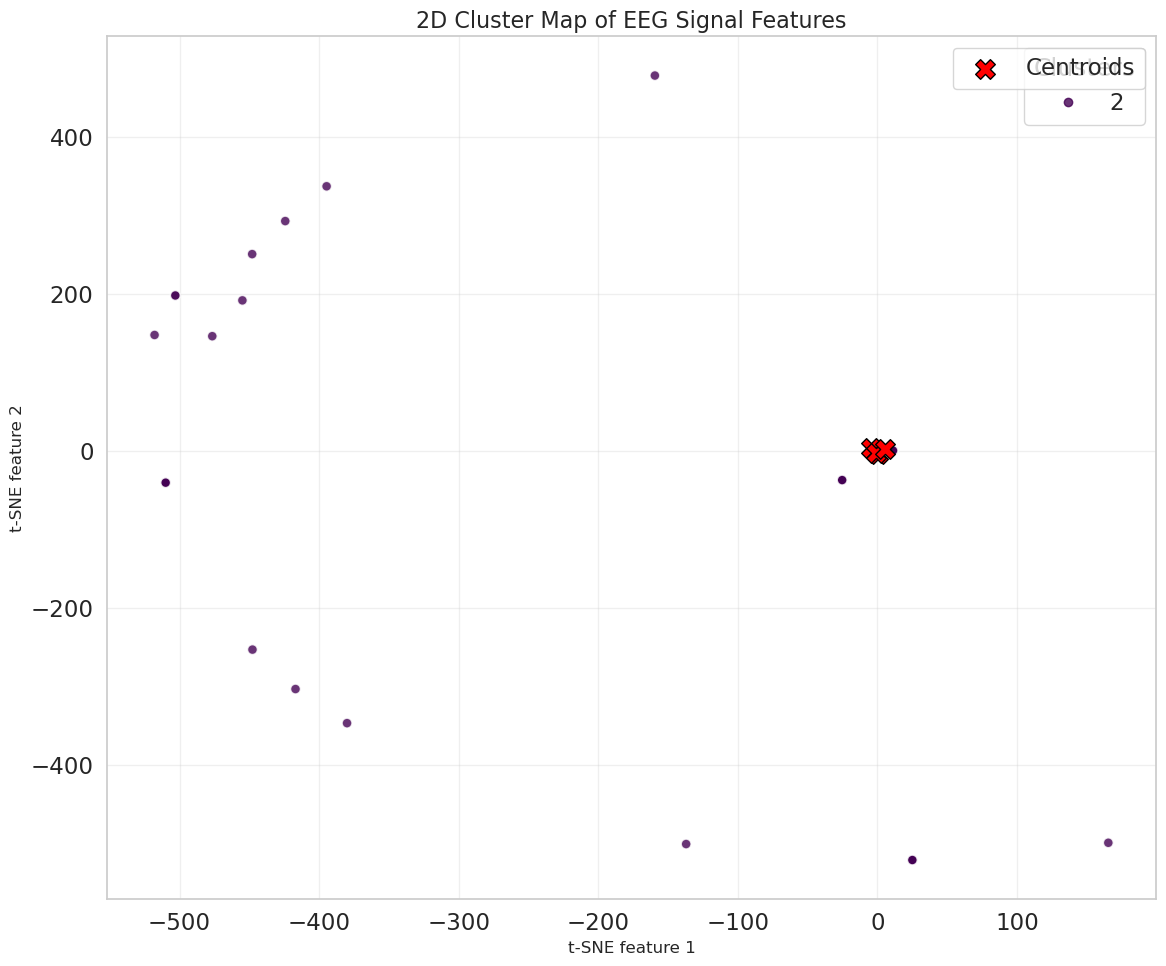

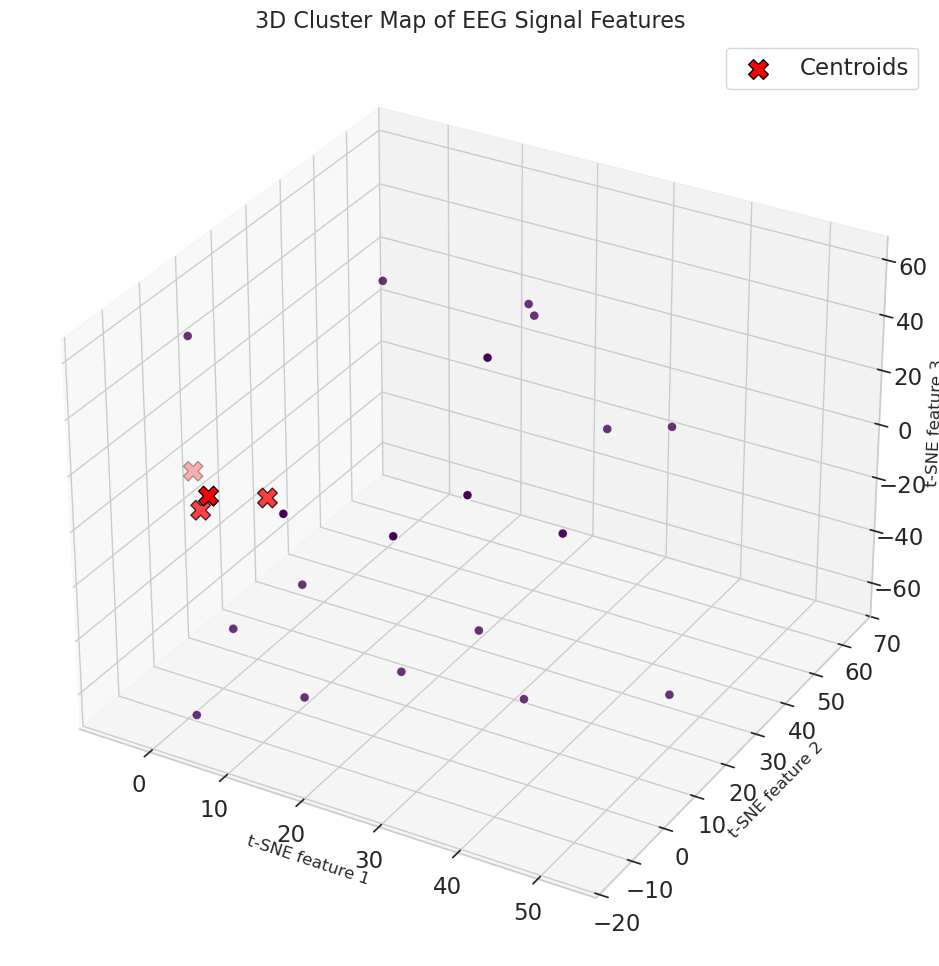

In [28]:
# Apply t-SNE to reduce features to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

# Create a cluster map
plt.figure(figsize=(12, 10))

# Scatter plot with cluster colors
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_cluster_predictions, 
                     cmap='viridis', alpha=0.8, s=50, edgecolors='w')

# Add legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)

# Add cluster centroids - use a different approach for few points
centroids = model.cluster_centroids.cpu().detach().numpy()
if centroids.shape[0] < 30:
    # Use PCA instead of t-SNE for small number of centroids
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    centroids_2d = pca.fit_transform(centroids)
else:
    # Use t-SNE with adjusted perplexity
    tsne_centroids = TSNE(n_components=2, random_state=42, 
                       perplexity=min(centroids.shape[0]//2, 5))
    centroids_2d = tsne_centroids.fit_transform(centroids)

plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='red', 
           marker='X', edgecolors='black', label='Centroids')

plt.title('2D Cluster Map of EEG Signal Features', fontsize=16)
plt.xlabel('t-SNE feature 1', fontsize=12)
plt.ylabel('t-SNE feature 2', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create 3D visualization if desired
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE to reduce features to 3D for visualization
tsne_3d = TSNE(n_components=3, random_state=42)
features_3d = tsne_3d.fit_transform(all_features)

# Create a 3D cluster map
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster colors
scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                    c=all_cluster_predictions, cmap='viridis', 
                    alpha=0.8, s=50, edgecolors='w')

# Add cluster centroids
if centroids.shape[0] < 30:
    # Use PCA instead of t-SNE for small number of centroids
    pca_3d = PCA(n_components=3)
    centroids_3d = pca_3d.fit_transform(centroids)
else:
    # Use t-SNE with adjusted perplexity
    tsne_centroids_3d = TSNE(n_components=3, random_state=42, 
                          perplexity=min(centroids.shape[0]//2, 5))
    centroids_3d = tsne_centroids_3d.fit_transform(centroids)

ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], 
          s=200, c='red', marker='X', edgecolors='black', label='Centroids')

ax.set_title('3D Cluster Map of EEG Signal Features', fontsize=16)
ax.set_xlabel('t-SNE feature 1', fontsize=12)
ax.set_ylabel('t-SNE feature 2', fontsize=12)
ax.set_zlabel('t-SNE feature 3', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

## Plot EEG Signal with Predicted Clusters

Plot the EEG signal with rectangles indicating the predicted cluster for each time window.

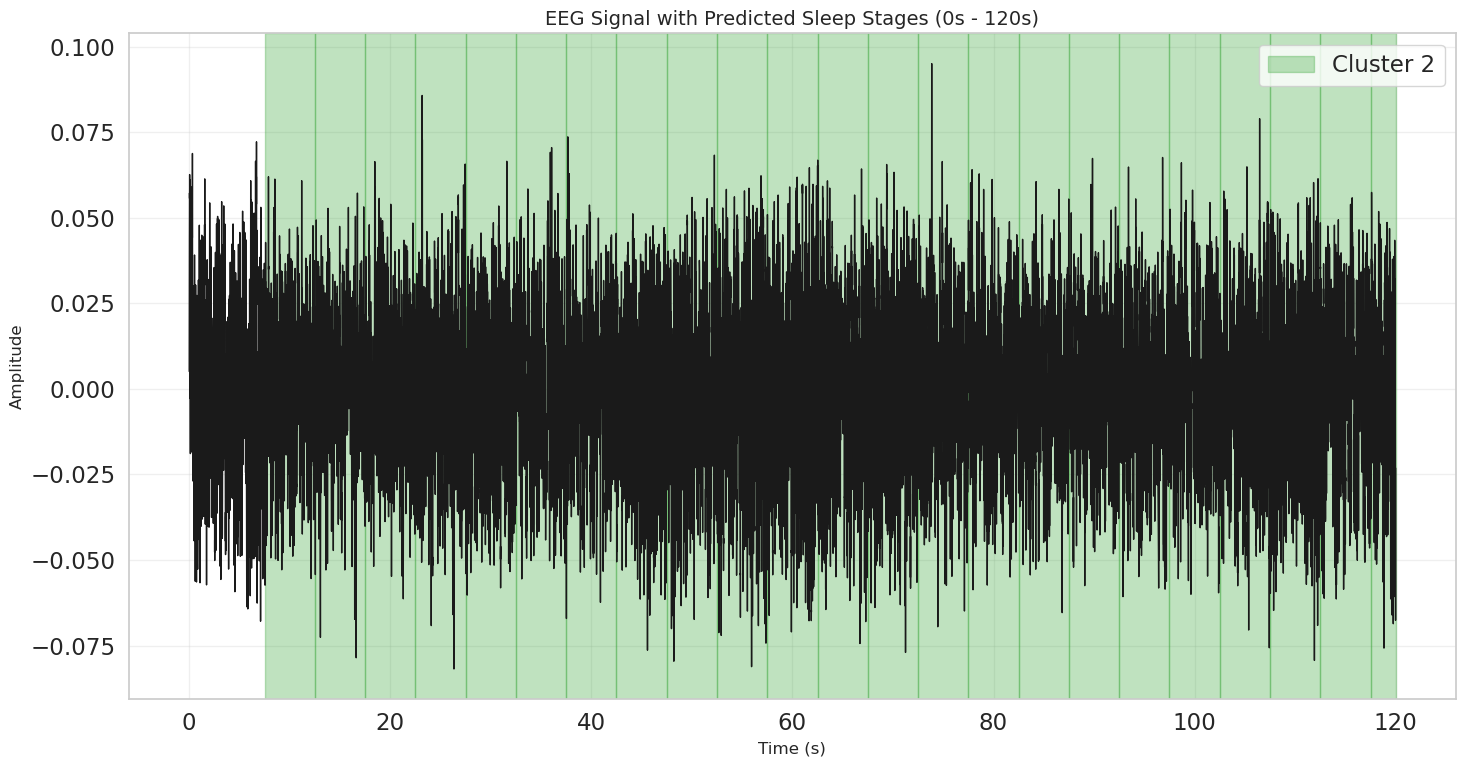

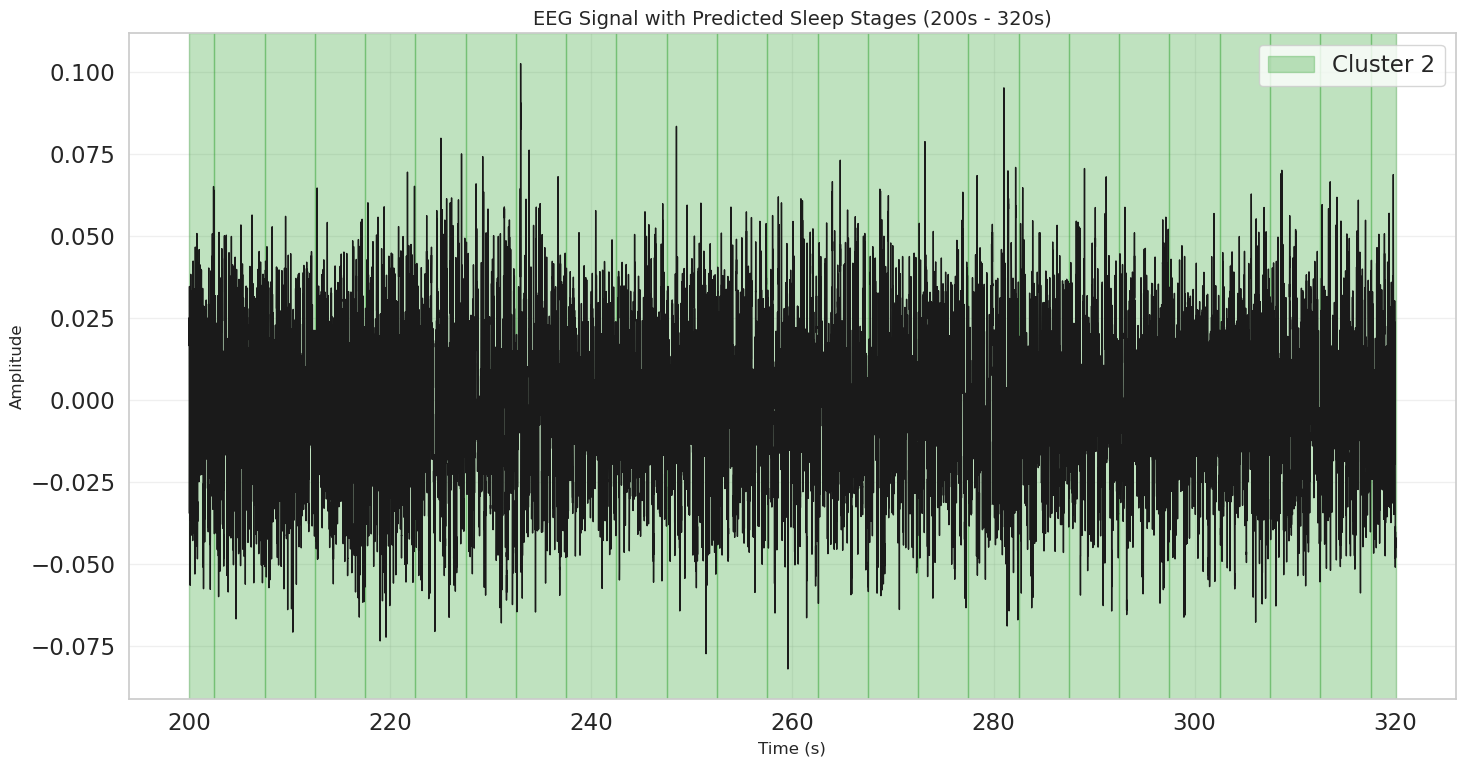

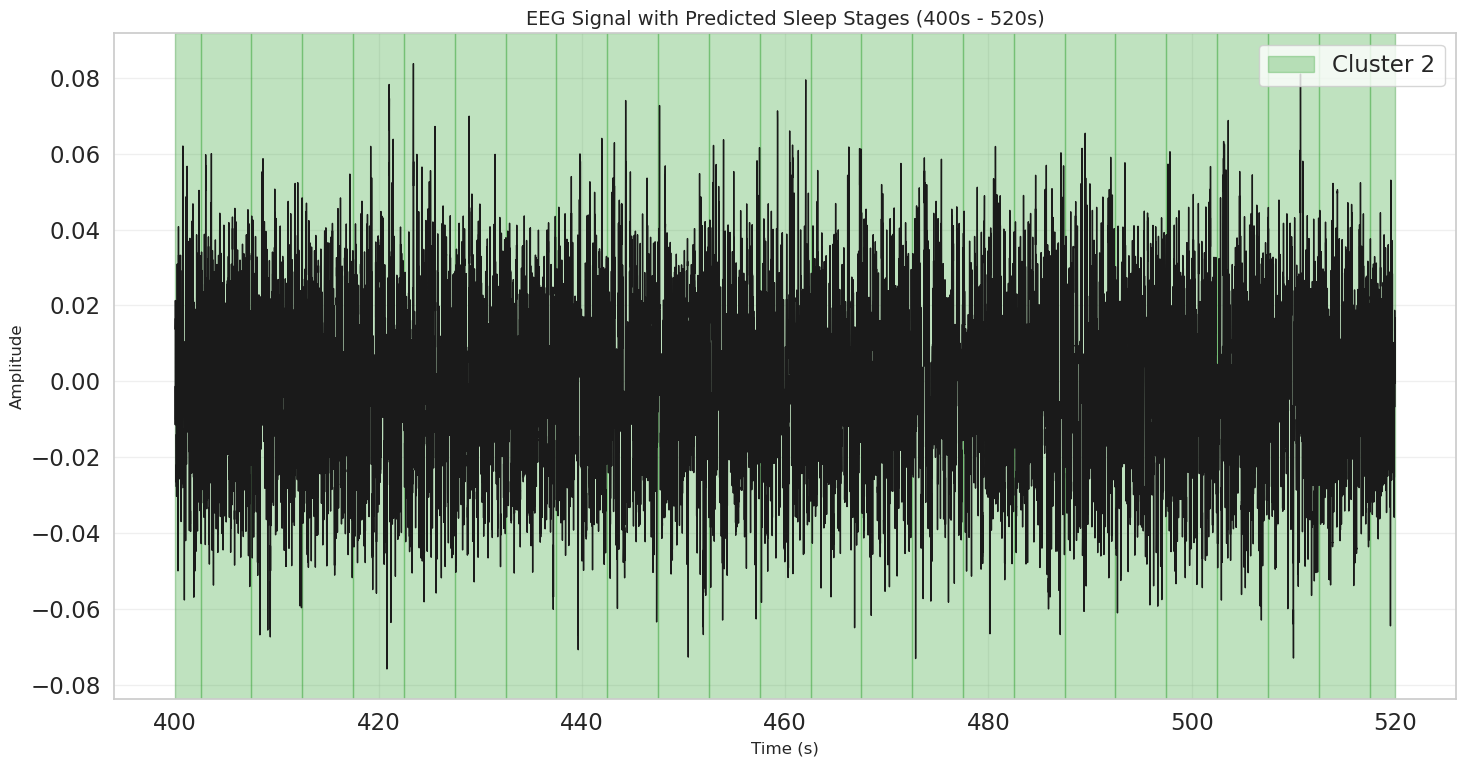

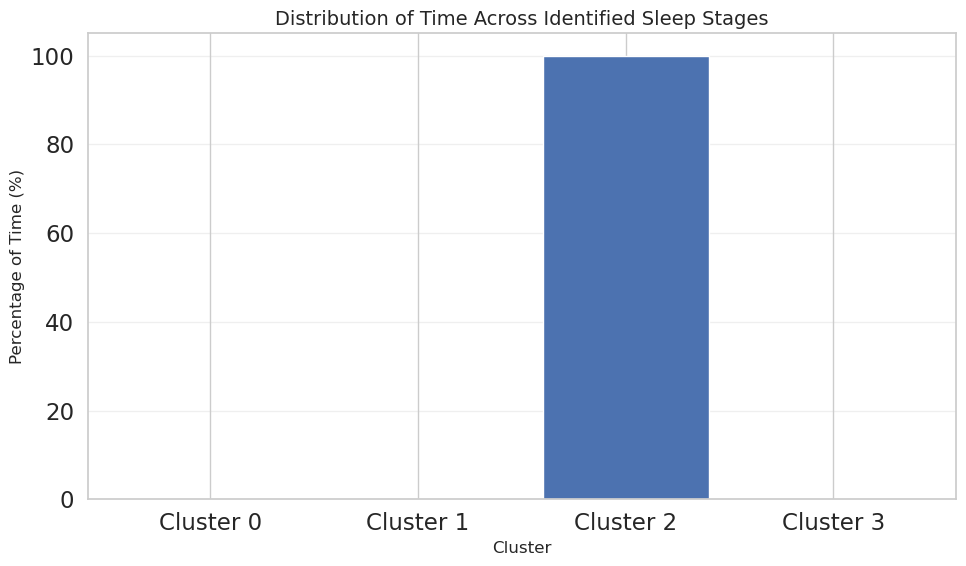

Cluster distribution:
Cluster 0: 0.0% of time
Cluster 1: 0.0% of time
Cluster 2: 100.0% of time
Cluster 3: 0.0% of time


In [29]:
# Create a function to plot the EEG signal with clusters
def plot_eeg_with_clusters(signal, time_array, cluster_times, cluster_labels, 
                          window_size, start_time=0, duration=120):
    """
    Plot EEG signal with clusters highlighted
    
    Parameters:
    - signal: EEG signal array
    - time_array: time points corresponding to signal
    - cluster_times: time points for each cluster prediction
    - cluster_labels: cluster label for each time point
    - window_size: window size in samples
    - start_time: start time for plot (seconds)
    - duration: duration to plot (seconds)
    """
    # Convert times to indices
    start_idx = int(start_time * fs)
    end_idx = int((start_time + duration) * fs)
    
    if end_idx > len(signal):
        end_idx = len(signal)
    
    # Set up plot
    plt.figure(figsize=(15, 8))
    
    # Plot signal
    plt.plot(time_array[start_idx:end_idx], signal[start_idx:end_idx], 'k-', linewidth=1)
    
    # Define colors for clusters
    cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # Plot cluster regions
    for i, (t, label) in enumerate(zip(cluster_times, cluster_labels)):
        if t < start_time or t > start_time + duration:
            continue
        
        # Calculate window boundaries
        half_window = window_size / (2 * fs)
        xmin = t - half_window
        xmax = t + half_window
        
        # Only show if window is in our view
        if xmax < start_time or xmin > start_time + duration:
            continue
            
        # Clip to visible area
        xmin = max(xmin, start_time)
        xmax = min(xmax, start_time + duration)
        
        # Get y range
        y_range = plt.ylim()
        
        # Add colored rectangle
        color = cluster_colors[label % len(cluster_colors)]
        plt.axvspan(xmin, xmax, alpha=0.3, color=color, label=f'Cluster {label}')
    
    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.title(f'EEG Signal with Predicted Sleep Stages ({start_time}s - {start_time+duration}s)', 
              fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# Plot several sections of the signal with clusters
sections = [
    (0, 120),    # First 2 minutes
    (200, 120),  # Middle section
    (400, 120)   # Later section
]

for start_time, duration in sections:
    # Convert the valid_times from relative (snapshot) to absolute time
    absolute_times = valid_times
    
    plot_eeg_with_clusters(
        signal=filtered_eeg, 
        time_array=time, 
        cluster_times=absolute_times, 
        cluster_labels=valid_predictions, 
        window_size=dmd_window_size,  # Use the DMD window size
        start_time=start_time, 
        duration=duration
    )
    plt.show()

# Create a summary of time spent in each cluster
cluster_counts = np.bincount(valid_predictions, minlength=num_clusters)
cluster_percentages = 100 * cluster_counts / np.sum(cluster_counts)

plt.figure(figsize=(10, 6))
plt.bar(range(num_clusters), cluster_percentages)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage of Time (%)', fontsize=12)
plt.title('Distribution of Time Across Identified Sleep Stages', fontsize=14)
plt.xticks(range(num_clusters), [f'Cluster {i}' for i in range(num_clusters)])
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Cluster distribution:")
for i in range(num_clusters):
    print(f"Cluster {i}: {cluster_percentages[i]:.1f}% of time")

## Conclusion

In this notebook, we've implemented an unsupervised deep learning pipeline for classifying sleep stages in rat EEG signal data. The pipeline includes:

1. Data loading and preprocessing
2. Bandpass filtering and normalization
3. Outlier interpolation
4. Feature extraction with Dynamic Mode Decomposition (DMD)
5. Unsupervised clustering with a transformer-based model
6. Visualization and evaluation of clustering results

This approach enables automatic identification of sleep stages without requiring labeled data, which can be valuable for neuroscience research involving large amounts of EEG recordings.

Further improvements could include:
- Fine-tuning the number of clusters
- Incorporating other physiological signals
- Comparing results with expert-labeled data when available
- Exploring different feature extraction methods